In [1]:
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.autograd as autograd

from common.multiprocessing_env import SubprocVecEnv
from common.sokoban_own import Sokoban

In [2]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

<h4>USE CUDA</h4>

In [3]:
USE_CUDA = torch.cuda.is_available()
Variable = lambda *args, **kwargs: autograd.Variable(*args, **kwargs).cuda() if USE_CUDA else autograd.Variable(*args, **kwargs)

<h1>Actor Critic Algorithm</h1>

<h2>Abstract A2C class</h2>

In [4]:
class OnPolicy(nn.Module):
    def __init__(self):
        super(OnPolicy, self).__init__()
        
    def forward(self, x):
        raise NotImplementedError
        
    def act(self, x, deterministic=False):
        logit, value = self.forward(x)
        probs = F.softmax(logit)
        
        if deterministic:
            action = probs.max(1)[1]
        else:
            action = probs.multinomial(num_samples=1)
        
        return action
    
    def evaluate_actions(self, x, action):
        logit, value = self.forward(x)
        
        probs     = F.softmax(logit)
        log_probs = F.log_softmax(logit)
        
        action_log_probs = log_probs.gather(1, action)
        entropy = -(probs * log_probs).sum(1).mean()
        
        return logit, action_log_probs, value, entropy

<h2>Neural Network architecture for A2C</h2>

In [5]:
class ActorCritic(OnPolicy):
    def __init__(self, in_shape, num_actions):
        super(ActorCritic, self).__init__()
        
        self.in_shape = in_shape
               
        self.fc = nn.Sequential(
            nn.Linear(self.feature_size(), 512),
            nn.PReLU(),
            nn.Linear(512, 1024),
            nn.PReLU(),
            nn.Linear(1024, 512),
            nn.PReLU(),
            nn.Linear(512, 256),
            nn.PReLU(),
        )
        
        self.critic  = nn.Linear(256, 1)
        self.actor   = nn.Linear(256, num_actions)
        
    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        logit = self.actor(x)
        value = self.critic(x)
        return logit, value
    
    def feature_size(self):
        return autograd.Variable(torch.zeros(1, *self.in_shape)).view(1, -1).size(1)

In [6]:
from torchsummary import summary
summary(ActorCritic((3, 7, 7), 4), (3, 7, 7), device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 512]          75,776
             PReLU-2                  [-1, 512]               1
            Linear-3                 [-1, 1024]         525,312
             PReLU-4                 [-1, 1024]               1
            Linear-5                  [-1, 512]         524,800
             PReLU-6                  [-1, 512]               1
            Linear-7                  [-1, 256]         131,328
             PReLU-8                  [-1, 256]               1
            Linear-9                    [-1, 4]           1,028
           Linear-10                    [-1, 1]             257
Total params: 1,258,505
Trainable params: 1,258,505
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.04
Params size (MB): 4.80
Estimat

<h2>Simple class to save expirience for A2C update</h2>

In [7]:
# @ikostrikov style

class RolloutStorage(object):
    def __init__(self, num_steps, num_envs, state_shape):
        self.num_steps = num_steps
        self.num_envs  = num_envs
        self.states  = torch.zeros(num_steps + 1, num_envs, *state_shape)
        self.rewards = torch.zeros(num_steps,     num_envs, 1)
        self.masks   = torch.ones(num_steps  + 1, num_envs, 1)
        self.actions = torch.zeros(num_steps,     num_envs, 1).long()
        self.use_cuda = False
            
    def cuda(self):
        self.use_cuda  = True
        self.states    = self.states.cuda()
        self.rewards   = self.rewards.cuda()
        self.masks     = self.masks.cuda()
        self.actions   = self.actions.cuda()
        
    def insert(self, step, state, action, reward, mask):
        self.states[step + 1].copy_(state)
        self.actions[step].copy_(action)
        self.rewards[step].copy_(reward)
        self.masks[step + 1].copy_(mask)
        
    def after_update(self):
        self.states[0].copy_(self.states[-1])
        self.masks[0].copy_(self.masks[-1])
        
    def compute_returns(self, next_value, gamma):
        returns   = torch.zeros(self.num_steps + 1, self.num_envs, 1)
        if self.use_cuda:
            returns = returns.cuda()
        returns[-1] = next_value
        for step in reversed(range(self.num_steps)):
            returns[step] = returns[step + 1] * gamma * self.masks[step + 1] + self.rewards[step]
        return returns[:-1]

<h1>Creating environments</h1>

In [8]:
num_envs = 16

def make_env():
    def _thunk():
        env = Sokoban(dim_room=(7, 7), max_steps=120, num_boxes=2, shape=(3, 7, 7), render_mode='tiny_rgb_array')
        return env

    return _thunk

envs = [make_env() for i in range(num_envs)]
envs = SubprocVecEnv(envs)

state_shape = envs.observation_space.shape

[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Wa

[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Ret

[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model wit

[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Ret

[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Run

[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Wa

[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOK

[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (

[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with sc

[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Ret

[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warnin

[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warnin

[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOK

[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOK

[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOK

[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .


[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warnin

[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warnin

[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry .

[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (

[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Wa

[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.


[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to pl

[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOK

[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Wa

[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.


[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warnin

[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOK

[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOK

[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.


[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with sc

[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warnin

[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warnin

[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#2) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.


[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOK

[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry .

[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOK

[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warnin

[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warnin

[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOK

[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warnin

[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Wa

[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warnin

[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Err

[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with sc

[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOK

[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Ret

[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOK

[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Ret

[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOK

[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not en

[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warnin

[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warnin

[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warnin

[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warnin

[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warnin

[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warnin

[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warnin

[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warnin

[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warnin

[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOK

[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model wit

[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOK

[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (

[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Wa

[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Wa

[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (

[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Wa

[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .


[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player 

[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model wit

[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.


[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warnin

[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Wa

[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with sc

[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with sc

[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Ret

[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model wit

[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 

[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#2) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0


[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOK

[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warnin

[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warnin

[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warnin

[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warnin

[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Ret

[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warnin

[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Wa

[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Ret

[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with sc

[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with sc

[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Ret

[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with sc

[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry .

[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.


[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with sc

[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with sc

[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with sc

[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (

[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with sc

[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.


[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOK

[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Wa

[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#2) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOK

[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (

[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warnin

[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (

[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warnin

[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Ret

[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warnin

[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0


[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime

[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Genera

[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Ret

[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Not enough free spots (#3) to place 1 player and 2 boxes.
[SOKOBAN] Retry . . .
[SOK

<h2>Init and Train</h2>

In [9]:
#a2c hyperparams:
gamma = 0.99
entropy_coef = 0.01
value_loss_coef = 0.5
max_grad_norm = 0.5
num_steps = 5
num_frames = int(10e5)

#rmsprop hyperparams:
lr    = 7e-4
eps   = 1e-5
alpha = 0.99

#Init a2c and rmsprop
actor_critic = ActorCritic(envs.observation_space.shape, envs.action_space.n)
optimizer = optim.Adam(actor_critic.parameters())  # , lr, eps=eps, alpha=alpha)
    
if USE_CUDA:
    actor_critic = actor_critic.cuda()

In [10]:
rollout = RolloutStorage(num_steps, num_envs, envs.observation_space.shape)
rollout.cuda()

all_rewards = []
all_losses  = []

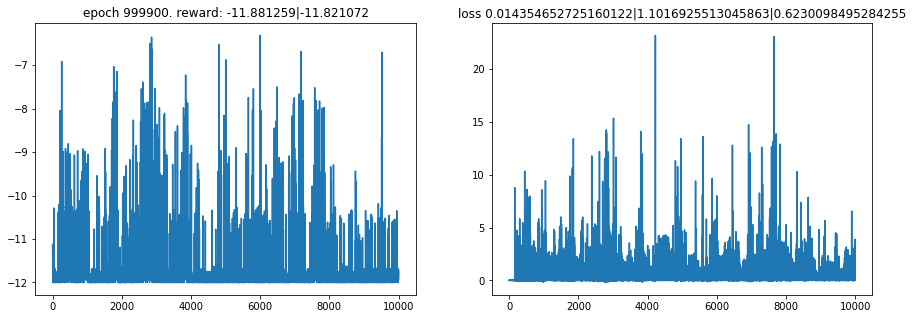

100%|█████████▉| 999900/1000000 [14:07:25<00:07, 13.24it/s]

In [11]:
state = envs.reset()
state = torch.FloatTensor(np.float32(state))

rollout.states[0].copy_(state)

episode_rewards = torch.zeros(num_envs, 1)
final_rewards   = torch.zeros(num_envs, 1)

import tqdm
bar = tqdm.tqdm(total=num_frames)

for i_update in range(num_frames):

    for step in range(num_steps):
        action = actor_critic.act(Variable(state))

        next_state, reward, done, _ = envs.step(action.squeeze(1).cpu().data.numpy())

        reward = torch.FloatTensor(reward).unsqueeze(1)
        episode_rewards += reward
        masks = torch.FloatTensor(1-np.array(done)).unsqueeze(1)
        final_rewards *= masks
        final_rewards += (1-masks) * episode_rewards
        episode_rewards *= masks

        if USE_CUDA:
            masks = masks.cuda()

        state = torch.FloatTensor(np.float32(next_state))
        rollout.insert(step, state, action.data, reward, masks)


    _, next_value = actor_critic(Variable(rollout.states[-1], volatile=True))
    next_value = next_value.data

    returns = rollout.compute_returns(next_value, gamma)

    logit, action_log_probs, values, entropy = actor_critic.evaluate_actions(
        Variable(rollout.states[:-1]).view(-1, *state_shape),
        Variable(rollout.actions).view(-1, 1)
    )

    values = values.view(num_steps, num_envs, 1)
    action_log_probs = action_log_probs.view(num_steps, num_envs, 1)
    advantages = Variable(returns) - values

    value_loss = advantages.pow(2).mean()
    action_loss = -(Variable(advantages.data) * action_log_probs).mean()

    optimizer.zero_grad()
    loss = value_loss * value_loss_coef + action_loss - entropy * entropy_coef
    loss.backward()
    nn.utils.clip_grad_norm(actor_critic.parameters(), max_grad_norm)
    optimizer.step()
    
    if i_update % 100 == 0 and i_update > 0:
        all_rewards.append(final_rewards.mean())
        all_losses.append(loss.data.item())
        
        clear_output(True)
        plt.figure(figsize=(15, 5))
        plt.subplot(121)
        plt.title('epoch %s. reward: %s|%s' % (i_update, np.mean(all_rewards[-10:]), np.mean(all_rewards[-100:])))
        plt.plot(all_rewards)
        plt.subplot(122)
        plt.title('loss %s|%s|%s' % (all_losses[-1], np.mean(all_losses[-10:]), np.mean(all_losses[-100:])))
        plt.plot(all_losses)
        plt.show()
        
        bar.update(100)
        
    rollout.after_update()

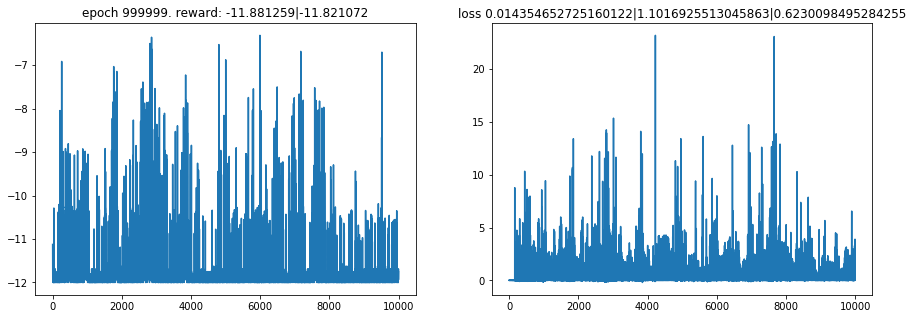

In [16]:
plt.figure(figsize=(15, 5))
plt.subplot(121)
plt.title('epoch %s. reward: %s|%s' % (i_update, np.mean(all_rewards[-10:]), np.mean(all_rewards[-100:])))
plt.plot(all_rewards)
plt.subplot(122)
plt.title('loss %s|%s|%s' % (all_losses[-1], np.mean(all_losses[-10:]), np.mean(all_losses[-100:])))
plt.plot(all_losses)
plt.savefig("02-actor-critic_own_arch_7x7_2.svg")

<h1>Saving the model!</h1>

In [17]:
torch.save(actor_critic.state_dict(), "02-actor-critic_own_arch_7x7_2-model.pth")

<h1>Let's see the game!<h1>

In [18]:
import time 

def displayImage(image, step, reward):
    clear_output(True)
    s = "step: " + str(step) + " reward: " + str(reward)
    plt.figure(figsize=(10,3))
    plt.title(s)
    plt.imshow(image / 255., cmap='gray')
    plt.show()
    time.sleep(0.1)

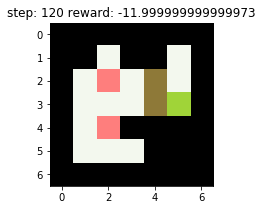

In [19]:
env = Sokoban(dim_room=(7, 7), max_steps=120, num_boxes=2, shape=(3, 7, 7), render_mode='tiny_rgb_array')

done = False
state = env.reset()
total_reward = 0
step   = 1


while not done:
    current_state = torch.FloatTensor(state).unsqueeze(0)
    if USE_CUDA:
        current_state = current_state.cuda()
        
    action = actor_critic.act(Variable(current_state))
    
    next_state, reward, done, _ = env.step(action.data[0, 0].item())
    total_reward += reward
    state = next_state
    
    image = torch.FloatTensor(state).permute(1, 2, 0).cpu().numpy()
    displayImage(image, step, total_reward)
    step += 1